In [1]:
!nvidia-smi

Sun May  1 16:33:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
dataset_dir = os.getcwd() + "/gdrive" + "/MyDrive" + "/dataset"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from glob import glob
import matplotlib.image as mpimg
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet152V2, Xception, DenseNet201
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
having_tumor = dataset_dir + "/yes"
normal = dataset_dir + "/no"

In [6]:
count_normal = 0
count_having_tumor = 0
for filename in os.listdir(having_tumor):
    if not filename.startswith('.'):
        count_having_tumor += 1
for filename in os.listdir(normal):
    if not filename.startswith('.'):
        count_normal += 1

In [7]:
print('images labelled as tumor: ', count_having_tumor)
print('\nimages labelled as normal: ', count_normal)
print('\ntotal images: ', count_having_tumor + count_normal)

images labelled as tumor:  1500

images labelled as normal:  1500

total images:  3000


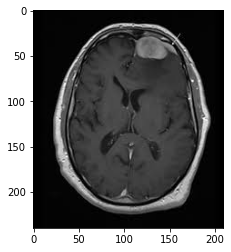

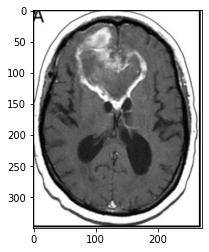

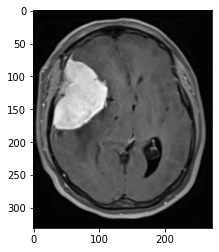

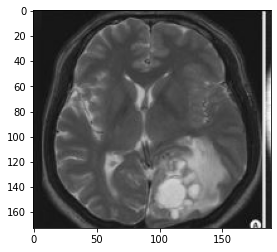

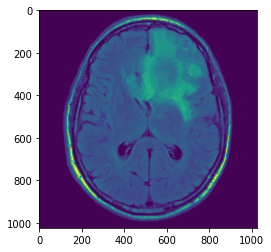

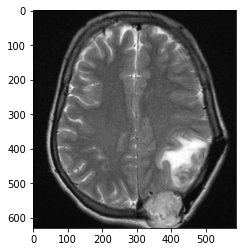

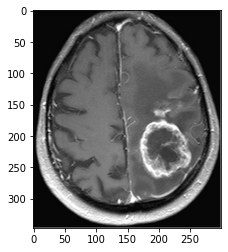

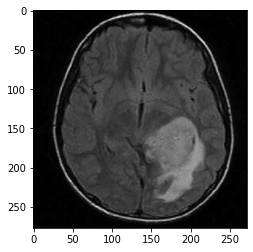

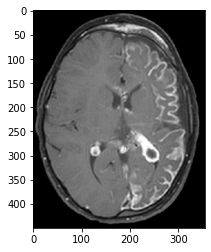

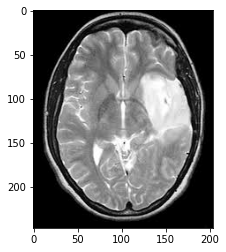

In [8]:
def process(filename: str=None) -> None:
    image = mpimg.imread(filename)
    plt.figure()
    plt.imshow(image)

i=0

for filename in os.listdir(having_tumor):
    if i<10:
        process(having_tumor + '/' + filename)
        i += 1
    else:
        break

In [ ]:
# Function for Image preprocessing
def processDataset(dataset_src, dataset_dest):
    # Making a Copy of Dataset
    shutil.copytree(src, dest)
    for folder in os.listdir(dest):
        for (index, filen) in enumerate(os.listdir(os.path.join(dest, folder)), start = 1):
            filename = f'{folder}_brain-tumor_{index}.jpg';
            img_src = os.path.join(dest, folder, filen);
            img_des = os.path.join(dest, folder, filename);
            # Preprocess the Images
            img = cv2.imread(img_src, );
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.GaussianBlur(img, (3,3), sigmaX=0)
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC);
            cv2.imwrite(img_des ,img);
            os.remove(img_src);

src = dataset_dir
dest = os.getcwd() + "/gdrive" + "/MyDrive" + "/BrainTumorDataset"
processDataset(src, dest)

In [9]:
BrainTumorDataset_dir = os.getcwd() + "/gdrive" + "/MyDrive" + "/BrainTumorDataset"

In [ ]:
## Function for Creating Train / Validation / Test folders (One time use Only)
 
def TrainValTestSplit(root_dir, classes_dir, val_ratio = 0.15, test_ratio = 0.15):
    main_folder = os.getcwd() + "/gdrive" + "/MyDrive" + '/BrainTumor_Splited_Data/';

    for cls in classes_dir:
        os.makedirs(main_folder + 'train' + cls)
        os.makedirs(main_folder + 'val' + cls)
        os.makedirs(main_folder + 'test' + cls)

        src = root_dir + cls
        
        allFileNames = os.listdir(src)
        print(allFileNames)
        np.random.seed(0)
        np.random.shuffle(allFileNames)

        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

        print(cls.upper(),':')
        print('Total images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Validation: ', len(val_FileNames))
        print('Testing: ', len(test_FileNames))

        for name in train_FileNames:
            shutil.copy(name, main_folder + 'train' + cls)

        for name in val_FileNames:
            shutil.copy(name, main_folder + 'val' + cls)

        for name in test_FileNames:
            shutil.copy(name, main_folder + 'test' + cls)
        print()

root_dir = BrainTumorDataset_dir              
classes_dir = ['/no', '/yes'] 
TrainValTestSplit(root_dir, classes_dir)

FileExistsError: ignored

In [10]:
BrainTumor_Splited_Data_dir =  os.getcwd() + "/gdrive" + "/MyDrive" + '/BrainTumor_Splited_Data/'

In [11]:
## Image Data Augmentation

train_datagen = ImageDataGenerator(rescale=1/255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.3,1.5],
                                   horizontal_flip=True,
                                   vertical_flip=True)

val_datagen = image.ImageDataGenerator(rescale = 1./255)

test_datagen = image.ImageDataGenerator(rescale = 1./255)

TRAIN_DIR = BrainTumor_Splited_Data_dir + "/train"
VAL_DIR = BrainTumor_Splited_Data_dir + "/val"
TEST_DIR = BrainTumor_Splited_Data_dir + "/test"

In [12]:
training_set = train_datagen.flow_from_directory(TRAIN_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

validation_set = val_datagen.flow_from_directory(VAL_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                shuffle=False)

testing_set = test_datagen.flow_from_directory(TEST_DIR,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical',
                                              shuffle=False)

Found 2100 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


### InceptionV3

In [13]:
image_size =[224, 224]

In [ ]:
inception = InceptionV3(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
    layer.trainable=False

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
filepath = 'incep_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [17]:
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

In [ ]:
x = (inception.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model1 = Model(inputs=inception.input, outputs=prediction)

In [ ]:
model1.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
r1 = model1.fit(
    training_set,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.6575 - accuracy: 0.5135
Epoch 1: val_accuracy improved from -inf to 0.67188, saving model to incep_best_model.hdf5
65/65 [==============================] - 468s 7s/step - loss: 1.6575 - accuracy: 0.5135 - val_loss: 0.6310 - val_accuracy: 0.6719
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.7226
Epoch 2: val_accuracy improved from 0.67188 to 0.86161, saving model to incep_best_model.hdf5
65/65 [==============================] - 42s 642ms/step - loss: 0.5800 - accuracy: 0.7226 - val_loss: 0.4705 - val_accuracy: 0.8616
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.4495 - accuracy: 0.8071
Epoch 3: val_accuracy did not improve from 0.86161
65/65 [==============================] - 41s 627ms/step - loss: 0.4495 - accuracy: 0.8071 - val_loss: 0.6030 - val_accuracy: 0.6272
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.4362 - accurac

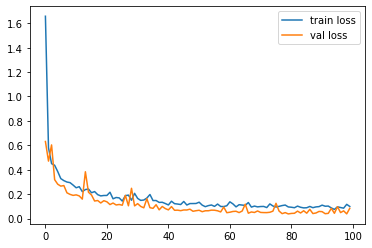

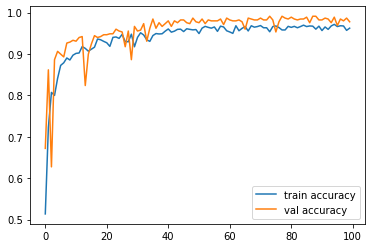

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r1.history['accuracy'], label='train accuracy')
plt.plot(r1.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy')

### Resnet152V2

In [ ]:
resnet = ResNet152V2(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
for layer in resnet.layers:
    layer.trainable=False

In [ ]:
x = (resnet.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model2 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [ ]:
filepath = 'res_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [ ]:
r2 = model2.fit(
    training_set,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.8130 - accuracy: 0.8182
Epoch 1: val_accuracy improved from -inf to 0.88616, saving model to res_best_model.hdf5
65/65 [==============================] - 70s 878ms/step - loss: 0.8130 - accuracy: 0.8182 - val_loss: 0.2790 - val_accuracy: 0.8862
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.8815
Epoch 2: val_accuracy improved from 0.88616 to 0.91295, saving model to res_best_model.hdf5
65/65 [==============================] - 53s 819ms/step - loss: 0.2897 - accuracy: 0.8815 - val_loss: 0.1899 - val_accuracy: 0.9129
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9067
Epoch 3: val_accuracy improved from 0.91295 to 0.94196, saving model to res_best_model.hdf5
65/65 [==============================] - 53s 811ms/step - loss: 0.2450 - accuracy: 0.9067 - val_loss: 0.1550 - val_accuracy: 0.9420
Epoch 4/100
65/65 [===========================

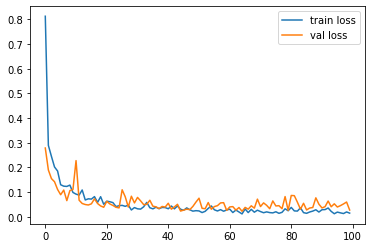

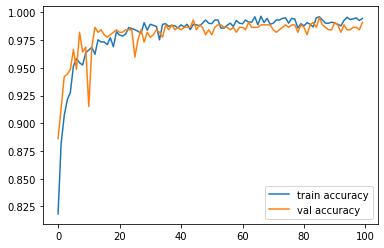

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r2.history['accuracy'], label='train accuracy')
plt.plot(r2.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy')

### Xception

In [14]:
xception = Xception(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [15]:
for layer in xception.layers:
    layer.trainable=False

In [19]:
x = (xception.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model3 = Model(inputs=xception.input, outputs=prediction)

In [20]:
model3.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [21]:
filepath = 'xcep_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [22]:
r3 = model3.fit(
    training_set,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.6944
Epoch 1: val_accuracy improved from -inf to 0.75893, saving model to xcep_best_model.hdf5
65/65 [==============================] - 298s 4s/step - loss: 0.7230 - accuracy: 0.6944 - val_loss: 0.4856 - val_accuracy: 0.7589
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8206
Epoch 2: val_accuracy improved from 0.75893 to 0.88170, saving model to xcep_best_model.hdf5
65/65 [==============================] - 48s 729ms/step - loss: 0.3958 - accuracy: 0.8206 - val_loss: 0.2904 - val_accuracy: 0.8817
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8598
Epoch 3: val_accuracy improved from 0.88170 to 0.89286, saving model to xcep_best_model.hdf5
65/65 [==============================] - 47s 720ms/step - loss: 0.3401 - accuracy: 0.8598 - val_loss: 0.2774 - val_accuracy: 0.8929
Epoch 4/100
65/65 [==========================

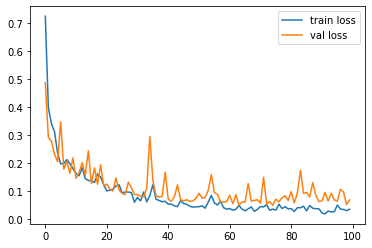

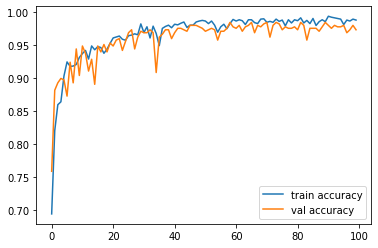

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r3.history['accuracy'], label='train accuracy')
plt.plot(r3.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy')

### DenseNet201

In [24]:
densenet = DenseNet201(input_shape = image_size + [3], include_top = False, weights = 'imagenet')

74850304/74836368 [==============================] - 1s 0us/step


In [25]:
for layer in densenet.layers:
    layer.trainable=False

In [26]:
filepath = 'dense_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [27]:
x = (densenet.output)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
prediction=Dense(2, activation='softmax')(x)

model4 = Model(inputs=densenet.input, outputs=prediction)

In [28]:
model4.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.001),
    metrics=['accuracy']
)

In [29]:
r4 = model4.fit(
    training_set,
    validation_data=validation_set,
    epochs = 100,
    steps_per_epoch = training_set.samples//training_set.batch_size,
    validation_steps = validation_set.samples//validation_set.batch_size,
    callbacks=callbacks
)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.9654 - accuracy: 0.6383
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to dense_best_model.hdf5
65/65 [==============================] - 72s 855ms/step - loss: 0.9654 - accuracy: 0.6383 - val_loss: 0.3279 - val_accuracy: 0.8571
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.7945
Epoch 2: val_accuracy did not improve from 0.85714
65/65 [==============================] - 49s 747ms/step - loss: 0.4325 - accuracy: 0.7945 - val_loss: 0.4862 - val_accuracy: 0.7321
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8868
Epoch 3: val_accuracy did not improve from 0.85714
65/65 [==============================] - 48s 737ms/step - loss: 0.2714 - accuracy: 0.8868 - val_loss: 0.4156 - val_accuracy: 0.8036
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9178
Epoch 4: val_accuracy improved 

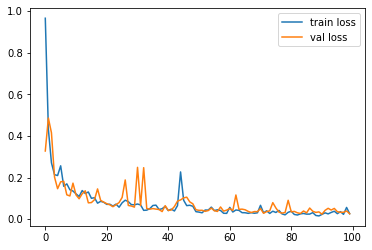

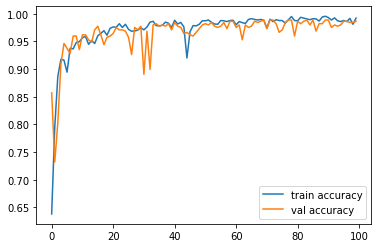

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(r4.history['loss'], label='train loss')
plt.plot(r4.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(r4.history['accuracy'], label='train accuracy')
plt.plot(r4.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('LossVal_accuracy')

### Individual Model Evaluation

In [31]:
model1 = load_model('/content/gdrive/MyDrive/incep_best_model.hdf5')
model2 = load_model('/content/gdrive/MyDrive/res_best_model.hdf5')
model3 = load_model('/content/xcep_best_model.hdf5')
model4 = load_model('/content/dense_best_model.hdf5')

#### InceptionV3

In [33]:
accuracy_model1_training = model1.evaluate_generator(generator= training_set)[1]
accuracy_model1_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.977142870426178

In [34]:
accuracy_model1_validation = model1.evaluate_generator(generator= validation_set)[1]
accuracy_model1_validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9911110997200012

In [35]:
accuracy_model1_test = model1.evaluate_generator(generator= testing_set)[1]
accuracy_model1_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9844444394111633

In [40]:
model1_training_pred = model1.predict(training_set)
model1_validation_pred = model1.predict(validation_set)
model1_testing_pred = model1.predict(testing_set)

model1_training_pred = np.argmax(model1_training_pred, axis = 1)
model1_validation_pred = np.argmax(model1_validation_pred, axis = 1)
model1_testing_pred = np.argmax(model1_testing_pred, axis = 1)

In [37]:
test_true_classes = testing_set.classes
test_class_labels = list(testing_set.class_indices.keys())
val_true_classes = validation_set.classes
val_class_labels = list(validation_set.class_indices.keys())
train_true_classes = training_set.classes
train_class_labels = list(training_set.class_indices.keys())

In [43]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_model1_train = confusion_matrix(train_true_classes, model1_training_pred)
cf_matrix_model1_val = confusion_matrix(val_true_classes, model1_validation_pred)
cf_matrix_model1_test = confusion_matrix(test_true_classes, model1_testing_pred)


##### confussion Matrix plots

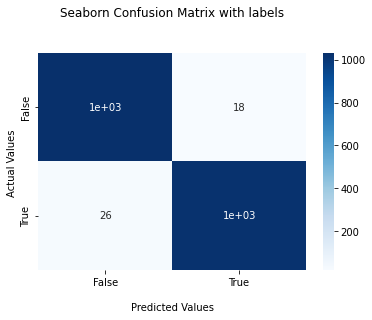

In [46]:
import seaborn as sns
ax = sns.heatmap(cf_matrix_model1_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

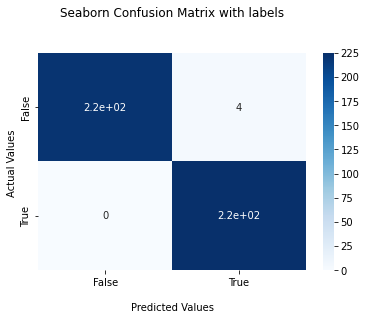

In [47]:
ax = sns.heatmap(cf_matrix_model1_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

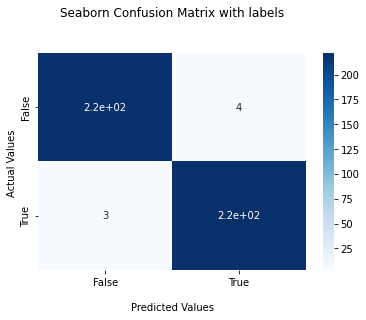

In [48]:
ax = sns.heatmap(cf_matrix_model1_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [49]:
### Classification Report
print(classification_report(train_true_classes, model1_training_pred, target_names=train_class_labels))

              precision    recall  f1-score   support

          no       0.98      0.98      0.98      1050
         yes       0.98      0.98      0.98      1050

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [50]:
print(classification_report(val_true_classes, model1_validation_pred, target_names=val_class_labels))

              precision    recall  f1-score   support

          no       1.00      0.98      0.99       225
         yes       0.98      1.00      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [51]:
print(classification_report(test_true_classes, model1_testing_pred, target_names=test_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.98      0.98       225
         yes       0.98      0.99      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



#### Resnet152V2

In [52]:
accuracy_model2_training = model2.evaluate_generator(generator= training_set)[1]
accuracy_model2_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9971428513526917

In [62]:
accuracy_model2_val = model2.evaluate_generator(generator= validation_set)[1]
accuracy_model2_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.995555579662323

In [54]:
accuracy_model2_test = model2.evaluate_generator(generator= testing_set)[1]
accuracy_model2_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9911110997200012

In [55]:
model2_training_pred = model2.predict(training_set)
model2_validation_pred = model2.predict(validation_set)
model2_testing_pred = model2.predict(testing_set)

model2_training_pred = np.argmax(model2_training_pred, axis = 1)
model2_validation_pred = np.argmax(model2_validation_pred, axis = 1)
model2_testing_pred = np.argmax(model2_testing_pred, axis = 1)

In [56]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_model2_train = confusion_matrix(train_true_classes, model2_training_pred)
cf_matrix_model2_val = confusion_matrix(val_true_classes, model2_validation_pred)
cf_matrix_model2_test = confusion_matrix(test_true_classes, model2_testing_pred)

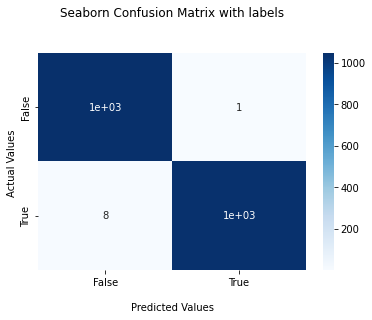

In [57]:
ax = sns.heatmap(cf_matrix_model2_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

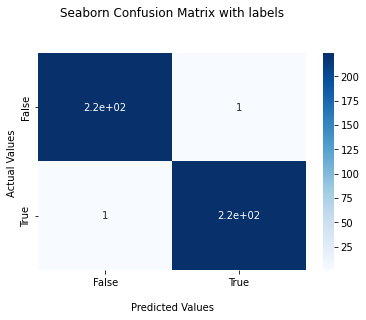

In [59]:
ax = sns.heatmap(cf_matrix_model2_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

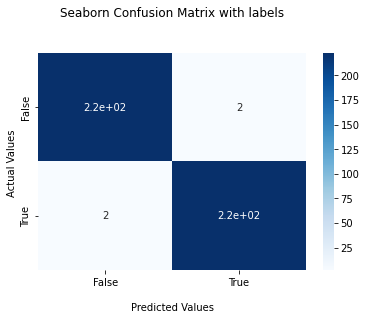

In [61]:
ax = sns.heatmap(cf_matrix_model2_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
### Classification Report
print(classification_report(train_true_classes, model2_training_pred, target_names=train_class_labels))

              precision    recall  f1-score   support

          no       0.99      1.00      1.00      1050
         yes       1.00      0.99      1.00      1050

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



In [65]:
### Classification Report
print(classification_report(val_true_classes, model2_validation_pred, target_names=val_class_labels))

              precision    recall  f1-score   support

          no       1.00      1.00      1.00       225
         yes       1.00      1.00      1.00       225

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



In [66]:
### Classification Report
print(classification_report(test_true_classes, model2_testing_pred, target_names=test_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.99      0.99       225
         yes       0.99      0.99      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



#### Xception

In [67]:
accuracy_model3_training = model3.evaluate_generator(generator= training_set)[1]
accuracy_model3_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.988095223903656

In [69]:
accuracy_model3_val = model3.evaluate_generator(generator= validation_set)[1]
accuracy_model3_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9844444394111633

In [70]:
accuracy_model3_test = model3.evaluate_generator(generator= testing_set)[1]
accuracy_model3_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9822221994400024

In [71]:
model3_training_pred = model3.predict(training_set)
model3_validation_pred = model3.predict(validation_set)
model3_testing_pred = model3.predict(testing_set)

model3_training_pred = np.argmax(model3_training_pred, axis = 1)
model3_validation_pred = np.argmax(model3_validation_pred, axis = 1)
model3_testing_pred = np.argmax(model3_testing_pred, axis = 1)

In [72]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_model3_train = confusion_matrix(train_true_classes, model3_training_pred)
cf_matrix_model3_val = confusion_matrix(val_true_classes, model3_validation_pred)
cf_matrix_model3_test = confusion_matrix(test_true_classes, model3_testing_pred)

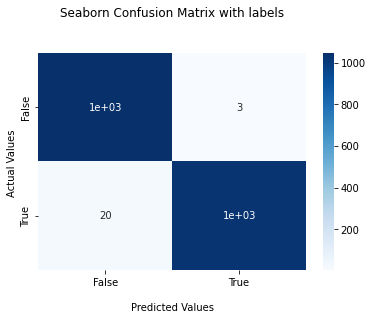

In [73]:
ax = sns.heatmap(cf_matrix_model3_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

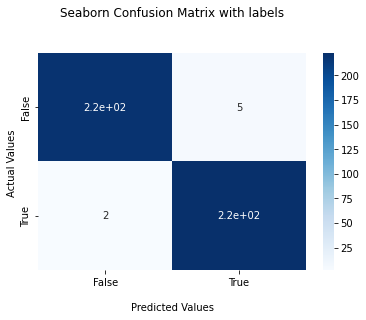

In [74]:
ax = sns.heatmap(cf_matrix_model3_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

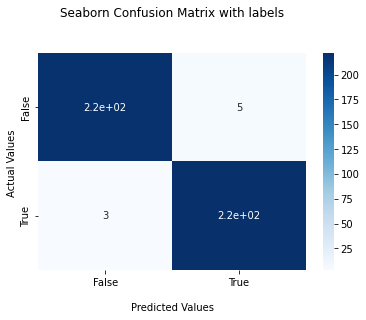

In [75]:
ax = sns.heatmap(cf_matrix_model3_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [76]:
### Classification Report
print(classification_report(train_true_classes, model3_training_pred, target_names=train_class_labels))

              precision    recall  f1-score   support

          no       0.98      1.00      0.99      1050
         yes       1.00      0.98      0.99      1050

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



In [77]:
### Classification Report
print(classification_report(val_true_classes, model3_validation_pred, target_names=val_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.98      0.98       225
         yes       0.98      0.99      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



In [79]:
### Classification Report
print(classification_report(test_true_classes, model3_testing_pred, target_names=test_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.98      0.98       225
         yes       0.98      0.99      0.98       225

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



#### DenseNet201

In [82]:
accuracy_model4_training = model4.evaluate_generator(generator= training_set)[1]
accuracy_model4_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9952380657196045

In [83]:
accuracy_model4_val = model4.evaluate_generator(generator= validation_set)[1]
accuracy_model4_val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9888888597488403

In [84]:
accuracy_model4_test = model4.evaluate_generator(generator= testing_set)[1]
accuracy_model4_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.9888888597488403

In [85]:
model4_training_pred = model4.predict(training_set)
model4_validation_pred = model4.predict(validation_set)
model4_testing_pred = model4.predict(testing_set)

model4_training_pred = np.argmax(model4_training_pred, axis = 1)
model4_validation_pred = np.argmax(model4_validation_pred, axis = 1)
model4_testing_pred = np.argmax(model4_testing_pred, axis = 1)

In [86]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_model4_train = confusion_matrix(train_true_classes, model4_training_pred)
cf_matrix_model4_val = confusion_matrix(val_true_classes, model4_validation_pred)
cf_matrix_model4_test = confusion_matrix(test_true_classes, model4_testing_pred)

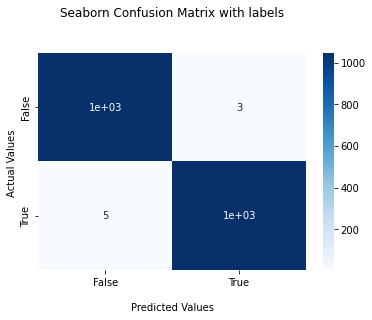

In [87]:
ax = sns.heatmap(cf_matrix_model4_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

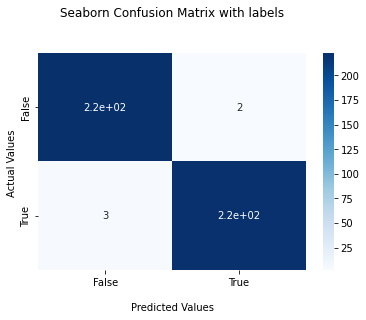

In [88]:
ax = sns.heatmap(cf_matrix_model4_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

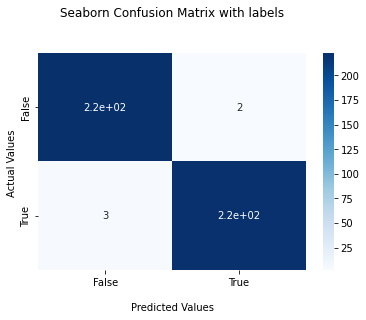

In [89]:
ax = sns.heatmap(cf_matrix_model4_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [90]:
### Classification Report
print(classification_report(train_true_classes, model4_training_pred, target_names=train_class_labels))

              precision    recall  f1-score   support

          no       1.00      1.00      1.00      1050
         yes       1.00      1.00      1.00      1050

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



In [91]:
### Classification Report
print(classification_report(val_true_classes, model4_validation_pred, target_names=val_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.99      0.99       225
         yes       0.99      0.99      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [92]:
### Classification Report
print(classification_report(test_true_classes, model4_testing_pred, target_names=test_class_labels))

              precision    recall  f1-score   support

          no       0.99      0.99      0.99       225
         yes       0.99      0.99      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



### Ensemble

In [93]:
models = [model1, model2, model3, model4]

In [95]:
train_preds = [model.predict(training_set) for model in models]
train_preds = np.array(train_preds)
summed_train = np.sum(train_preds, axis = 0)

val_preds = [model.predict(validation_set) for model in models]
val_preds = np.array(val_preds)
summed_val = np.sum(val_preds, axis = 0)

test_preds = [model.predict(testing_set) for model in models]
test_preds = np.array(test_preds)
summed_test = np.sum(test_preds, axis = 0)

In [96]:
ensemble_train_pred = np.argmax(summed_train, axis = 1)
ensemble_val_pred = np.argmax(summed_val, axis = 1)
ensemble_test_pred = np.argmax(summed_test, axis = 1)

In [97]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_ensemble_train = confusion_matrix(train_true_classes, ensemble_train_pred)
cf_matrix_ensemble_val = confusion_matrix(val_true_classes, ensemble_val_pred)
cf_matrix_ensemble_test = confusion_matrix(test_true_classes, ensemble_test_pred)

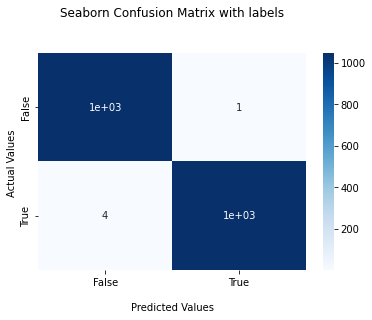

In [98]:
ax = sns.heatmap(cf_matrix_ensemble_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

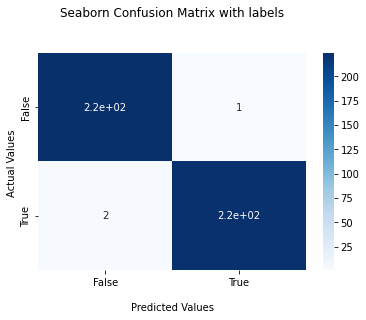

In [99]:
ax = sns.heatmap(cf_matrix_ensemble_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

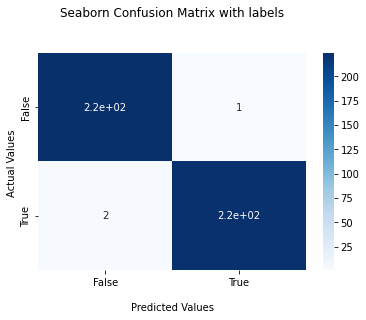

In [100]:
ax = sns.heatmap(cf_matrix_ensemble_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [101]:
### Classification Report
print(classification_report(train_true_classes, ensemble_train_pred, target_names=train_class_labels))

              precision    recall  f1-score   support

          no       1.00      1.00      1.00      1050
         yes       1.00      1.00      1.00      1050

    accuracy                           1.00      2100
   macro avg       1.00      1.00      1.00      2100
weighted avg       1.00      1.00      1.00      2100



In [102]:
### Classification Report
print(classification_report(val_true_classes, ensemble_val_pred, target_names=val_class_labels))

              precision    recall  f1-score   support

          no       0.99      1.00      0.99       225
         yes       1.00      0.99      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



In [103]:
### Classification Report
print(classification_report(test_true_classes, ensemble_test_pred, target_names=test_class_labels))

              precision    recall  f1-score   support

          no       0.99      1.00      0.99       225
         yes       1.00      0.99      0.99       225

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



##### With weights

###### better training accuracy

In [104]:
df_best_train = pd.DataFrame([])

In [105]:
for w1 in range(0,20):
    for w2 in range(0,20):
        for w3 in range(0,20):
            for w4 in range(0,20):
                wts = [w1/10, w2/10, w3/10, w4/10]
                weighted_train_pred = np.tensordot(train_preds, wts, axes=((0),(0)))
                weighted_train_ensemble_preds = np.argmax(weighted_train_pred, axis=1)
                wa = accuracy_score(train_true_classes, weighted_train_ensemble_preds)
                df_best_train = df_best_train.append({'wt1': w1, 'wt2': w2,
                                'wt3': w3, 'wt4': w4, 'acc': wa}, ignore_index=True)

In [106]:
max_train_acc = df_best_train.iloc[df_best_train['acc'].idxmax()]
print(max_train_acc)

wt1    0.000000
wt2    1.000000
wt3    2.000000
wt4    1.000000
acc    0.999524
Name: 441, dtype: float64


In [107]:
weights = [0, 1, 2, 1]

In [109]:
weighted_val_pred = np.tensordot(val_preds, weights, axes=((0),(0)))
weighted_val_ensemble_preds = np.argmax(weighted_val_pred, axis=1)

weighted_test_pred = np.tensordot(test_preds, weights, axes=((0),(0)))
weighted_test_ensemble_preds = np.argmax(weighted_test_pred, axis=1)

weighted_train_pred = np.tensordot(train_preds, weights, axes=((0),(0)))
weighted_train_ensemble_preds = np.argmax(weighted_train_pred, axis=1)

In [110]:
accuracy_score(test_true_classes, weighted_test_ensemble_preds)

0.9933333333333333

In [111]:
accuracy_score(val_true_classes, weighted_val_ensemble_preds)

0.9888888888888889

In [113]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_ensemble_train = confusion_matrix(train_true_classes, weighted_train_ensemble_preds)
cf_matrix_ensemble_val = confusion_matrix(val_true_classes, weighted_val_ensemble_preds)
cf_matrix_ensemble_test = confusion_matrix(test_true_classes, weighted_test_ensemble_preds)

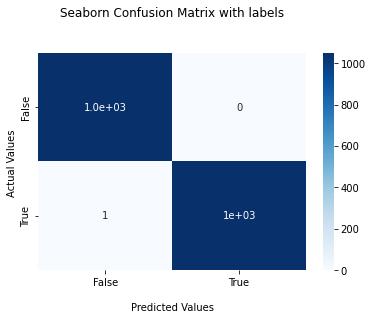

In [114]:
ax = sns.heatmap(cf_matrix_ensemble_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

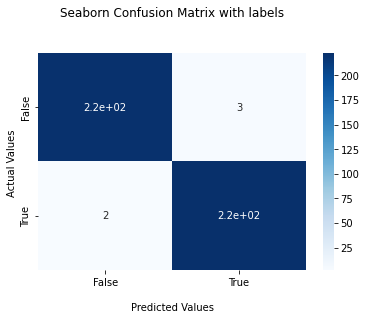

In [115]:
ax = sns.heatmap(cf_matrix_ensemble_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

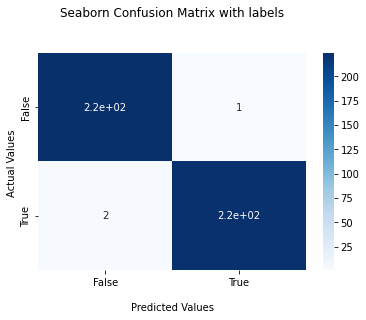

In [116]:
ax = sns.heatmap(cf_matrix_ensemble_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

#### for better validation

In [117]:
df_best_val = pd.DataFrame([])

In [118]:
for w1 in range(0,20):
    for w2 in range(0,20):
        for w3 in range(0,20):
            for w4 in range(0,20):
                wts = [w1/10, w2/10, w3/10, w4/10]
                weighted_val_pred = np.tensordot(val_preds, wts, axes=((0),(0)))
                weighted_val_ensemble_preds = np.argmax(weighted_val_pred, axis=1)
                wa = accuracy_score(val_true_classes, weighted_val_ensemble_preds)
                df_best_val = df_best_val.append({'wt1': w1, 'wt2': w2,
                                'wt3': w3, 'wt4': w4, 'acc': wa}, ignore_index=True)

In [119]:
max_train_acc = df_best_val.iloc[df_best_val['acc'].idxmax()]
print(max_train_acc)

wt1    4.000000
wt2    1.000000
wt3    2.000000
wt4    2.000000
acc    0.997778
Name: 32442, dtype: float64


In [120]:
weights = [4, 1, 2, 2]

In [121]:
weighted_val_pred = np.tensordot(val_preds, weights, axes=((0),(0)))
weighted_val_ensemble_preds = np.argmax(weighted_val_pred, axis=1)

weighted_test_pred = np.tensordot(test_preds, weights, axes=((0),(0)))
weighted_test_ensemble_preds = np.argmax(weighted_test_pred, axis=1)

weighted_train_pred = np.tensordot(train_preds, weights, axes=((0),(0)))
weighted_train_ensemble_preds = np.argmax(weighted_train_pred, axis=1)

In [122]:
accuracy_score(test_true_classes, weighted_test_ensemble_preds)

0.9933333333333333

In [123]:
accuracy_score(train_true_classes, weighted_train_ensemble_preds)

0.9961904761904762

In [124]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_ensemble_train = confusion_matrix(train_true_classes, weighted_train_ensemble_preds)
cf_matrix_ensemble_val = confusion_matrix(val_true_classes, weighted_val_ensemble_preds)
cf_matrix_ensemble_test = confusion_matrix(test_true_classes, weighted_test_ensemble_preds)

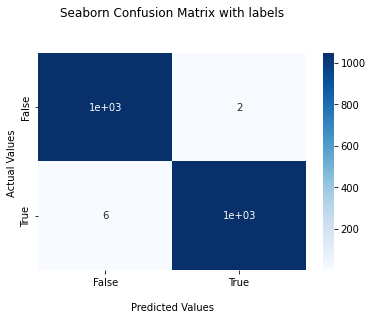

In [125]:
ax = sns.heatmap(cf_matrix_ensemble_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

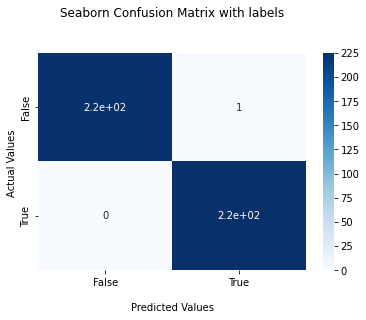

In [126]:
ax = sns.heatmap(cf_matrix_ensemble_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

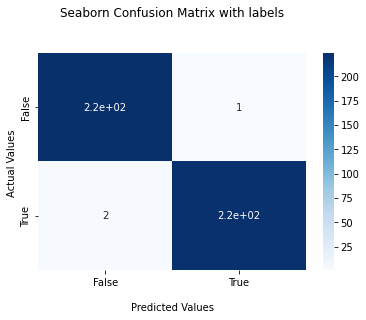

In [127]:
ax = sns.heatmap(cf_matrix_ensemble_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

#### better test

In [128]:
df_best_test = pd.DataFrame([])

In [129]:
for w1 in range(0,20):
    for w2 in range(0,20):
        for w3 in range(0,20):
            for w4 in range(0,20):
                wts = [w1/10, w2/10, w3/10, w4/10]
                weighted_test_pred = np.tensordot(test_preds, wts, axes=((0),(0)))
                weighted_test_ensemble_preds = np.argmax(weighted_test_pred, axis=1)
                wa = accuracy_score(test_true_classes, weighted_test_ensemble_preds)
                df_best_test = df_best_test.append({'wt1': w1, 'wt2': w2,
                                'wt3': w3, 'wt4': w4, 'acc': wa}, ignore_index=True)

In [131]:
max_test_acc = df_best_test.iloc[df_best_test['acc'].idxmax()]
print(max_test_acc)

wt1    2.000000
wt2    0.000000
wt3    1.000000
wt4    1.000000
acc    0.995556
Name: 16021, dtype: float64


In [132]:
weights = [2, 0, 1, 1]

In [133]:
weighted_val_pred = np.tensordot(val_preds, weights, axes=((0),(0)))
weighted_val_ensemble_preds = np.argmax(weighted_val_pred, axis=1)

weighted_test_pred = np.tensordot(test_preds, weights, axes=((0),(0)))
weighted_test_ensemble_preds = np.argmax(weighted_test_pred, axis=1)

weighted_train_pred = np.tensordot(train_preds, weights, axes=((0),(0)))
weighted_train_ensemble_preds = np.argmax(weighted_train_pred, axis=1)

In [134]:
accuracy_score(test_true_classes, weighted_test_ensemble_preds)

0.9955555555555555

In [135]:
accuracy_score(train_true_classes, weighted_train_ensemble_preds)

0.9961904761904762

In [136]:
accuracy_score(val_true_classes, weighted_val_ensemble_preds)

0.9911111111111112

In [137]:
##Confusion Matrix
#Generate the confusion matrix
cf_matrix_ensemble_train = confusion_matrix(train_true_classes, weighted_train_ensemble_preds)
cf_matrix_ensemble_val = confusion_matrix(val_true_classes, weighted_val_ensemble_preds)
cf_matrix_ensemble_test = confusion_matrix(test_true_classes, weighted_test_ensemble_preds)

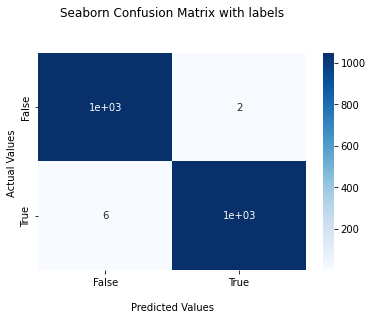

In [138]:
ax = sns.heatmap(cf_matrix_ensemble_train, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

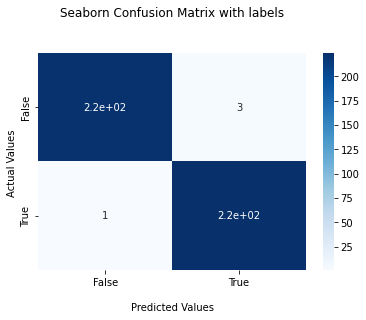

In [139]:
ax = sns.heatmap(cf_matrix_ensemble_val, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

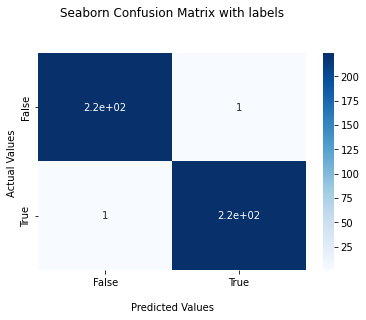

In [140]:
ax = sns.heatmap(cf_matrix_ensemble_test, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()